# Notebook para Trainamento do XGBoost

# Importar Bibliotecas Necessárias
Aqui importamos todas as bibliotecas necessárias que serão usadas neste notebook, incluindo o Pandas para manipulação de dados, XGBoost para construir o modelo de classificação, e várias funções do sklearn para avaliação do modelo.


In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pickle

# Carregar e Balancear o Conjunto de Dados
Nós carregamos os dados de um arquivo Parquet. Dado o possível problema de desbalanceamento de classes com a variável 'SUICIDIO', balanceamos o conjunto de dados subamostrando a classe majoritária para igualar a contagem da classe minoritária. Isso ajuda a evitar que o modelo tenha viés em direção à classe majoritária.


In [8]:
df = pd.read_parquet('../data/processed/sim_2006_2017_pre_processed.parquet')
suicidio_0 = df[df['SUICIDIO'] == 0]
suicidio_1 = df[df['SUICIDIO'] == 1]
suicidio_0_sample = suicidio_0.sample(n=len(suicidio_1), replace=False)
balanced_df = pd.concat([suicidio_0_sample, suicidio_1], ignore_index=True).reset_index(drop=True)
df

,ESC,ESTCIV,IDADE,NATURAL,OCUP,RACACOR,MASCULINO,FEMININO,SUICIDIO
0,-1.732328,0.809986,-0.187545,-1,0.844239,-0.484485,True,False,0
1,-0.226709,-0.329698,0.753377,-1,-1.066134,3.994021,True,False,0
2,-0.226709,0.240144,1.380658,-1,-0.337181,-0.484485,False,True,0
3,-0.226709,-0.899540,1.171564,-2,-1.066134,-0.484485,True,False,0
4,-1.732328,0.240144,0.701103,-1,-1.587212,-0.484485,False,True,0
...,...,...,...,...,...,...,...,...,...
3045770,-0.979518,-0.899540,-1.337560,35,0.844239,3.994021,False,True,0
3045771,-0.000199,3.659197,-0.082998,35,-1.587212,-0.484485,True,False,0
3045772,-0.226709,-0.899540,-0.605732,29,0.844239,1.194955,True,False,0
3045773,-0.226709,0.240144,1.067017,35,0.844239,-0.484485,True,False,0


In [9]:
with open("../models/stdscaler.pkl", "rb") as f:
    std=pickle.load((f))

In [10]:
X = balanced_df[['ESC', 'ESTCIV', 'IDADE' ,    'NATURAL' ,    'OCUP',    'RACACOR'    ,'MASCULINO',    'FEMININO'    ]].values
y = balanced_df['SUICIDIO'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preparar Dados para Treinamento
Aqui, selecionamos as características e a variável alvo do DataFrame balanceado, seguido pela divisão dos dados em conjuntos de treinamento e teste para avaliar o desempenho do modelo posteriormente.


In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=666)

# Treinar o Modelo XGBoost
Definimos e treinamos o classificador XGBoost. O XGBoost é escolhido por sua eficiência e eficácia em lidar com vários tipos de dados e por seu desempenho em tarefas de classificação.


In [11]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# Avaliar o Modelo
Após treinar o modelo, prevemos os resultados do conjunto de teste e avaliamos o desempenho do modelo usando acurácia, relatório de classificação e matriz de confusão. Essas métricas nos ajudam a entender a capacidade do modelo de generalizar dados não vistos, precisão, recall, f1-score e acurácia geral.

In [13]:
y_pred = xgb_clf.predict(X_test)
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79      4745
           1       0.78      0.81      0.79      4688

    accuracy                           0.79      9433
   macro avg       0.79      0.79      0.79      9433
weighted avg       0.79      0.79      0.79      9433

Matriz de Confusão:
 [[3694 1051]
 [ 912 3776]]


In [14]:
import shap
# Ajuste de hiperparâmetros com GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Avaliação do modelo
y_pred = best_model.predict(X_test)
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END c

In [15]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [17]:
# Avaliação do modelo
y_pred = best_model.predict(X_test)
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79      4745
           1       0.79      0.81      0.80      4688

    accuracy                           0.79      9433
   macro avg       0.80      0.79      0.79      9433
weighted avg       0.80      0.79      0.79      9433

Matriz de Confusão:
 [[3713 1032]
 [ 903 3785]]


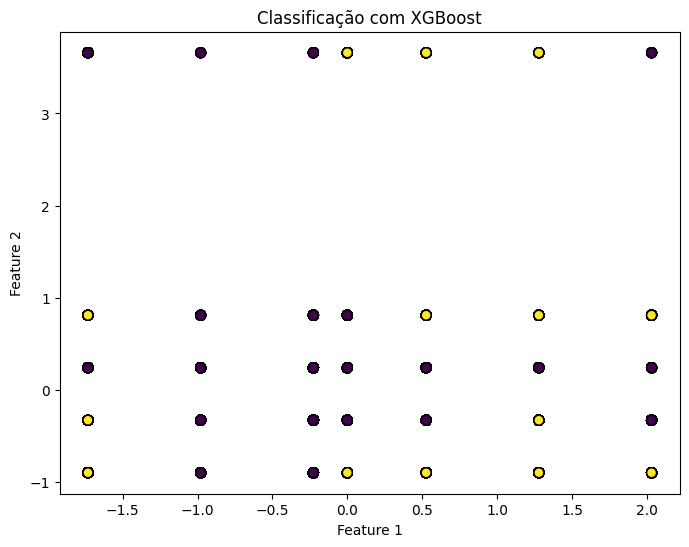

In [18]:
# Visualização dos dados
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred, cmap='viridis', edgecolors='black', s=50)
plt.title("Classificação com XGBoost")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

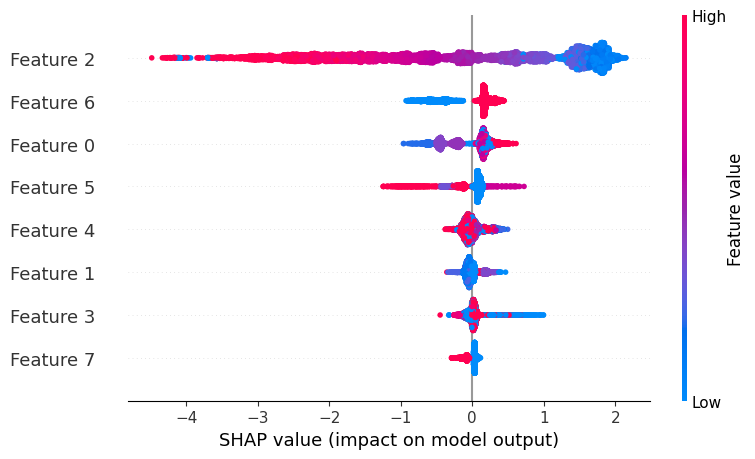

In [19]:
import shap
# Visualização com SHAP
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [20]:
geovanna = pd.DataFrame({'ESC': 5,    'ESTCIV': 1,    'IDADE': 22,    'NATURAL': 53,    'OCUP': -1,    'RACACOR': 4,    'MASCULINO': False,    'FEMININO': True}, index=[0])

arthur = pd.DataFrame({'ESC': 5,    'ESTCIV': 2,    'IDADE': 21,    'NATURAL': 52,    'OCUP': -1,    'RACACOR': 1,    'MASCULINO': True,    'FEMININO': False}, index=[0])

iranildo = pd.DataFrame({'ESC': 2,    'ESTCIV': 3,    'IDADE': 57,    'NATURAL': 23,    'OCUP': 999993,    'RACACOR': 1,    'MASCULINO': True,    'FEMININO': False}, index=[0])

genivaldo = pd.DataFrame({'ESC': 3,    'ESTCIV': 3,    'IDADE': 37,    'NATURAL': 35,    'OCUP': 2410,    'RACACOR': 1,    'MASCULINO': True,    'FEMININO': False}, index=[0])

doug = pd.DataFrame({'ESC': 5,    'ESTCIV': 2,    'IDADE': 21,    'NATURAL': 53,    'OCUP': 2410,    'RACACOR': 4,    'MASCULINO': True,    'FEMININO': False}, index=[0])

cozinheiro = pd.DataFrame({'ESC': 3,    'ESTCIV': 2,    'IDADE': 34,    'NATURAL': 29,    'OCUP': 5132,    'RACACOR': 4,    'MASCULINO': True,    'FEMININO': False}, index=[0])

npc_fga = pd.DataFrame({'ESC': 5,    'ESTCIV': 1,    'IDADE': 19,    'NATURAL': 53,    'OCUP': -1,    'RACACOR': 1,    'MASCULINO': True,    'FEMININO': False}, index=[0])

In [22]:
features = ['ESC', 'ESTCIV', 'IDADE', 'OCUP', 'RACACOR', 'NATURAL', 'MASCULINO', 'FEMININO']
teste = pd.concat((geovanna, arthur, doug, cozinheiro, iranildo, genivaldo, npc_fga), ignore_index=True)

teste[features[:-2]] = std.transform(teste[features[:-2]])
x = teste[features].values

y_pred_proba = best_model.predict_proba(x)
print("Predições (probabilidades):\n", y_pred_proba)

Predições (probabilidades):
 [[0.98852915 0.01147086]
 [0.91608566 0.08391435]
 [0.97642076 0.02357923]
 [0.97998035 0.02001963]
 [0.96655893 0.0334411 ]
 [0.97998035 0.02001963]
 [0.91608566 0.08391435]]


### SALVANDO O MODELO

In [ ]:
with open("../model/xgb_best_model.pkl", "wb") as f: